<a href="https://colab.research.google.com/github/jiwei911023/AirFrance_keyword_analysis/blob/master/ALEXNet_Jiwei_Li_Ants_Bees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip#how to import other dataset
!unzip hymenoptera_data
#what is current direcotory?

--2022-09-12 02:53:23--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.77, 18.160.200.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  80.8MB/s    in 0.6s    

2022-09-12 02:53:24 (80.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

--2022-09-12 02:53:24--  http://to/
Resolving to (to)... failed: No address associated with hostname.
wget: unable to resolve host address ‘to’
--2022-09-12 02:53:24--  http://import/
Resolving import (import)... failed: Name or service not known.
wget: unable to resolve host address ‘import’
--2022-09-12 02:53:24--  http://other/
Resolving other (other)... failed: Name or service not known.
wget: unable to resolve host addres

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as no
import time
import os
import copy
import matplotlib.pyplot as plt
cudnn.benchmark = True#???GPU寻找计算比较快的卷积算法
plt.ion()   # interactive mode#??

In [ ]:
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        #download=True)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
#Why differenct methods?
data_transforms = {#create a dict
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),#随机裁剪图片到224x224，数据增强，
        transforms.RandomHorizontalFlip(),#水平翻转
        transforms.ToTensor(),#transform the image data to the tensor data
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#中心化限定在一定的范围内？mean and std is based on experience and imagenet data?
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),#why using the different method?不需要数据增强
        transforms.CenterCrop(224),
        transforms.ToTensor(),#变成pytorch可以处理的向量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#根据经验的固定数值 mean + avg/根据imagenet数据
    ]),
}

data_dir = 'hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),#imagefolder load data? 
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,#data frame?workers?batch size?每次处理4张图片
                                             shuffle=True, num_workers=4)#cpu读取速度
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#whether using GPU or not. cuda=GPU/cuda:0 用第0个GPU

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
!nvidia-smi

Mon Sep 12 01:56:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    33W /  70W |   2428MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class_names

['ants', 'bees']

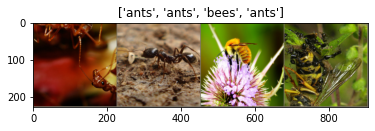

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))#col become row
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated?


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))#number of pictures?

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):#100/不断地找loss function，找最优模型
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()#?

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = torchvision.models.alexnet(pretrained=True)#Finetuning the convet Load a pretrained model and reset final fully connected layer.
#last fc
model_ft.classifier[6] = nn.Linear(4096,2)#predict 2 variables and modify the 6th row of classifier, linear=FC, only modify the last FC? How to set random weight to last FC?
#model_ft.fc = nn.Linear(num_ftrs, 2) #?
model_ft = model_ft.to(device)#?using GPU

#loss function/单独的函数
criterion = nn.CrossEntropyLoss()#related to backpropagation? ONLY used for last FC?WHAT is nn?why can not use softmax()? sum of prob is 1损失函数
#criterion = nn.Softmax()#related to backpropagation? ONLY used for last FC?WHAT is nn?概率输出。只是为了sum为1


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)#optimize weights based on backpropagation/lr:how quickly the optimization process/momentum: decreae the noise impact

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#o.oo1 * 0.1 for every 7 steps? step=epoch/optional

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
 print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9063 Acc: 0.5820
val Loss: 0.6704 Acc: 0.6144

Epoch 1/24
----------
train Loss: 0.6291 Acc: 0.6721
val Loss: 0.6424 Acc: 0.6471

Epoch 2/24
----------
train Loss: 0.6159 Acc: 0.6885
val Loss: 0.4515 Acc: 0.7843

Epoch 3/24
----------
train Loss: 0.5271 Acc: 0.7582
val Loss: 0.5728 Acc: 0.7124

Epoch 4/24
----------
train Loss: 0.4951 Acc: 0.7828
val Loss: 0.5541 Acc: 0.7386

Epoch 5/24
----------
train Loss: 0.5291 Acc: 0.7459
val Loss: 0.4180 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5348 Acc: 0.7705
val Loss: 0.5234 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.4351 Acc: 0.8361
val Loss: 0.5109 Acc: 0.7451

Epoch 8/24
----------
train Loss: 0.4055 Acc: 0.8197
val Loss: 0.5100 Acc: 0.7647

Epoch 9/24
----------
train Loss: 0.3913 Acc: 0.8279
val Loss: 0.5128 Acc: 0.7778

Epoch 10/24
----------
train Loss: 0.3517 Acc: 0.8443
val Loss: 0.5190 Acc: 0.7647

Epoch 11/24
----------
train Loss: 0.3275 Acc: 0.8689
val Loss: 0.5254 Acc: 0.7712

Epoch 12/24
----------


In [ ]:
visualize_model(model_ft)

NameError: ignored

In [ ]:
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False#?不等新参数。冻结。保证其他层的参数不变除了最后一个FC

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features#?
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)#GPU

criterion = nn.CrossEntropyLoss()#loss function

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)#optimize weight and bias

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)#optional and ajust the speed /related to lr/学习率低，找到最小loss function

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3981 Acc: 0.8115
val Loss: 0.1764 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.3058 Acc: 0.8689
val Loss: 0.1792 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.2851 Acc: 0.8975
val Loss: 0.1847 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3772 Acc: 0.8361
val Loss: 0.1799 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3237 Acc: 0.8320
val Loss: 0.1851 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.2875 Acc: 0.8852
val Loss: 0.1735 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4040 Acc: 0.8197
val Loss: 0.1681 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3106 Acc: 0.8361
val Loss: 0.1724 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3629 Acc: 0.8607
val Loss: 0.1782 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3532 Acc: 0.8607
val Loss: 0.1848 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3581 Acc: 0.8648
val Loss: 0.1849 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4025 Acc: 0.8279
val Loss: 0.1915 Acc: 0.9477

Ep

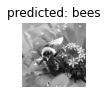

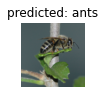

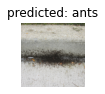

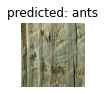

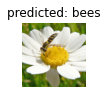

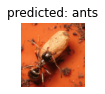

In [ ]:
visualize_model(model_conv)

plt.ioff()#?
plt.show()